### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

# MNIST CNN Digit Classification

This notebook demonstrates how to build and train a Convolutional Neural Network (CNN) for handwritten digit classification using the MNIST dataset and the helper functions from `modelling_helper.py`.

### Notebook Structure

1. **Import Libraries and Helper Functions**
2. **Load and Explore the MNIST Dataset**
3. **Visualize Sample Images**
4. **Data Preprocessing**
5. **Create and Build CNN Model**
6. **Train the Model**
7. **Evaluate Model Performance**
8. **Model Summary**
9. **Compiling the Model for AURIX&trade;**

## Import Libraries and Helper Functions

In [1]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.helper_functions import *
from modelling_helper import *

origin = "tf" # "tf" stands for TensorFlow

## Load and Explore the MNIST Dataset

This project uses the **MNIST Handwritten Digit Dataset**, a classic benchmark in machine learning and computer vision. The dataset contains:

- **Training data**: 60,000 handwritten digit images (28x28 pixels)
- **Test data**: 10,000 handwritten digit images for evaluation
- **10 classes**: Digits 0 through 9
- **Grayscale images**: Single channel, normalized pixel values

### Dataset Details

- **Image size**: 28×28 pixels, grayscale
- **Total samples**: 70,000 images
- **Classes**: 10 digit classes (0-9)
- **Format**: Preprocessed and normalized pixel values
- **Data split**: 54,000 training, 6,000 validation, 10,000 test samples

The MNIST dataset provides a controlled environment for demonstrating fundamental computer vision techniques that scale to more complex automotive applications. The small image size and computational requirements make it ideal for embedded system deployment validation.

**Data Source**: The dataset is automatically downloaded through TensorFlow/Keras and is part of the standard machine learning benchmarks.

In [2]:
# Load MNIST data
data = load_mnist_data(val_size=0.1)

x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]
x_test = data["x_test"]
y_test = data["y_test"]

print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")
print(f"Image shape: {x_train.shape[1:]}")
print(f"Number of classes: {len(np.unique(y_train))}")

Training set: 53969 samples
Validation set: 6031 samples
Test set: 10000 samples
Image shape: (28, 28)
Number of classes: 10


## Visualize Sample Images

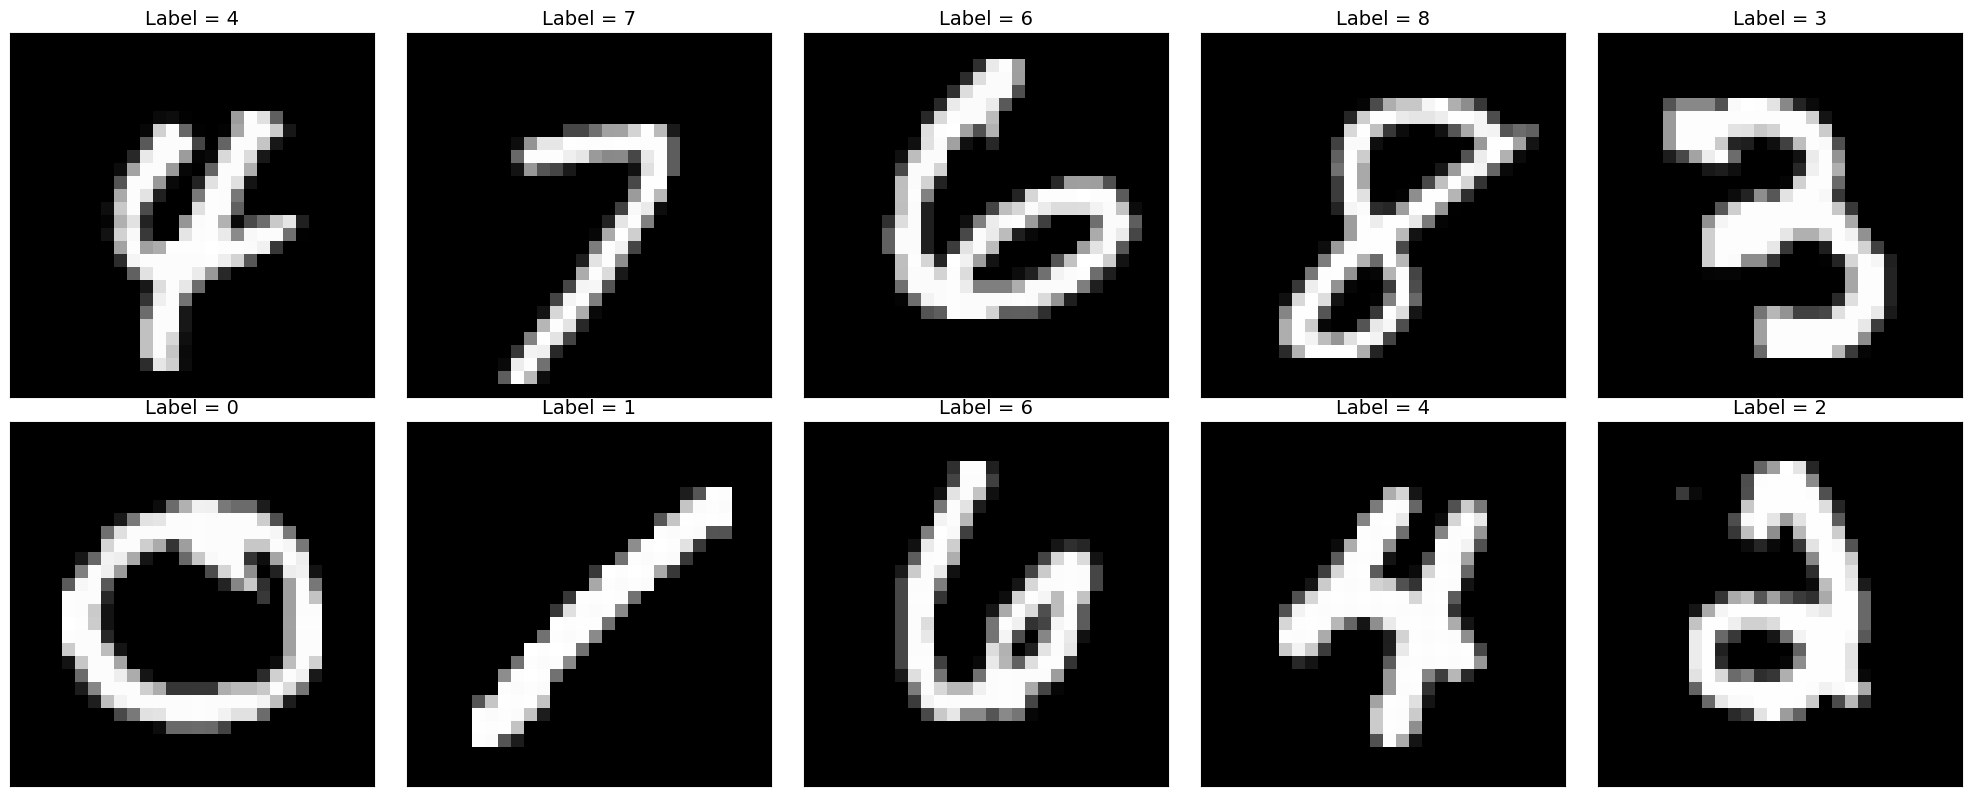

In [3]:
# Plot sample images
plot_sample_images(x_train, y_train, n_samples=10)

## Data Preprocessing

In [4]:
# Normalize pixel values to 0-1 range
x_train_norm, x_val_norm, x_test_norm = normalize_data(x_train, x_val, x_test)

print(f"Original pixel range: [{x_train.min()}, {x_train.max()}]")
print(f"Normalized pixel range: [{x_train_norm.min()}, {x_train_norm.max()}]")

# Prepare data for CNN by adding channel dimension
x_train_cnn, x_val_cnn, x_test_cnn = prepare_cnn_data(
    x_train_norm, x_val_norm, x_test_norm
)

print(f"CNN input shape: {x_train_cnn.shape[1:]}")

Original pixel range: [0, 255]
Normalized pixel range: [0.0, 1.0]
CNN input shape: (28, 28, 1)


## Create and Build CNN Model

### Convolutional Neural Network (CNN)
- **Architecture**: Convolutional layers with pooling and dense classification head
- **Input**: 28×28×1 images preserving spatial structure
- **Features**: Conv2D layers, MaxPooling, dropout, and dense layers
- **Output**: 10-class softmax classification
- **Use case**: Higher accuracy applications, spatial feature extraction

- Tweak the `conv_layers` list to test the effect of the model architecture on predictions. The first number of each tuple is the number of filters and the second the kernel size
- `dense_units` specifies the units of the dense layers following the convolutional layers.

In [5]:
# Get input and output shapes for CNN
input_shape, output_shape = get_input_output_shapes(x_train, y_train, model_type="cnn")

# Define CNN architecture
conv_layers = [(8, 3), (16, 3)]  # (filters, kernel_size)
dense_units = [16]  # Dense layer units
dropout_rate = 0.1

model = create_cnn_model(
    input_shape=input_shape,
    output_shape=output_shape,
    conv_layers=conv_layers,
    dense_units=dense_units,
    p_drop=dropout_rate,
)

# Display model summary
model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,978 (54.60 KB)

 Trainable params: 13,978 (54.60 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

- The training process uses early stopping to avoid overfitting.
- To ensure proper convergence learning rate reduction is used when training stalls.

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8432 - loss: 0.4844 - val_accuracy: 0.9607 - val_loss: 0.1431 - learning_rate: 0.0010
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9351 - loss: 0.2097 - val_accuracy: 0.9703 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9503 - loss: 0.1602 - val_accuracy: 0.9750 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9549 - loss: 0.1423 - val_accuracy: 0.9789 - val_loss: 0.0711 - learning_rate: 0.0010
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9615 - loss: 0.1226 - val_accuracy: 0.9804 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9652 - loss: 0.1117 - val_accuracy: 0.9818 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9672 - loss: 0.1034 - 

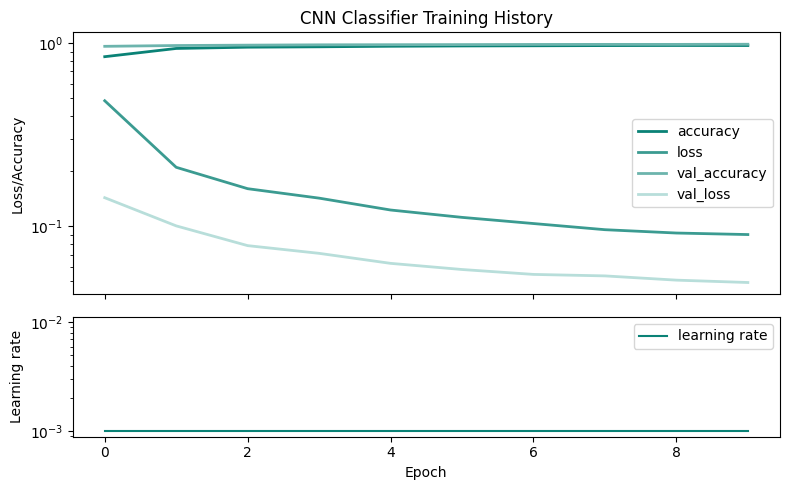

In [6]:
# Train the model
history = train_model(
    model=model,
    x_train=x_train_cnn,
    y_train=y_train,
    x_val=x_val_cnn,
    y_val=y_val,
    batch_size=64,
    epochs=10,
)

plot_training_history(history, model_name="CNN Classifier")

## Evaluate Model Performance

Test Loss: 0.0437
Test Accuracy: 0.9862 (98.62%)


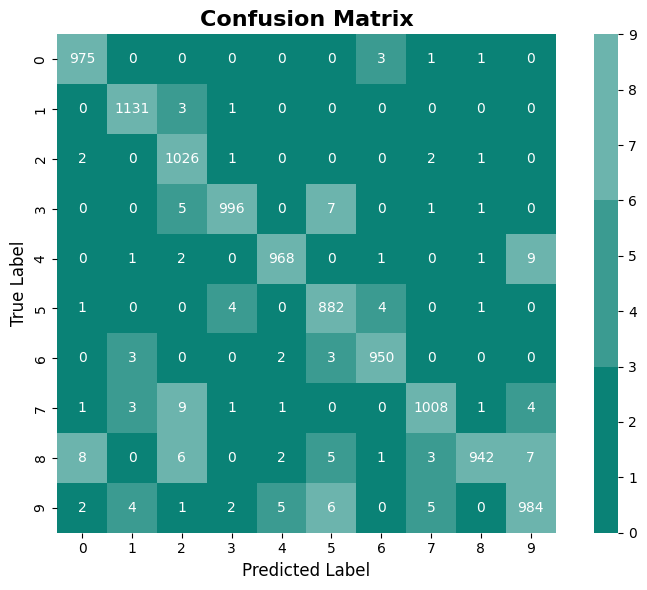

In [7]:
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, x_test_cnn, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Plot confusion matrix
plot_confusion_matrix(
    model, x_test_cnn, y_test, class_names=[str(i) for i in range(10)]
)

# Export Model to ONNX

- Generate a model name based on its architecture and loss
- Save the model together with a test in- & output

In [8]:
model_name = generate_model_name(model, test_accuracy, test_loss)

# Prepare input and output for model export (following RUL pattern)
input_target = x_train_cnn[0]  # Shape: (28, 28, 1) - unbatched
output_target = get_predictions(origin, model, input_target)

save_all(model_name, input_target, output_target, model, origin)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Directory created: out/cnn_model_layers_4_param_13978_accuracy_98-62_loss_0-04/test_cnn_model_layers_4_param_13978_accuracy_98-62_loss_0-04


# Convert Model for AURIX&trade; TC3x and TC4x deployment

- Make sure the docker container with conversion tools is running
- Submit the model together with test data to the container and download the generated code, binary and log files.
- Results are saved in the `out/<model_name>/test_<model_name>/<target>/` folder

In [9]:
ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


In [10]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


## Simulated execution timing

- For each node in the neural network the number of clock cycles is extracted from the log file and plotted.
- You can inspect which node is a computational bottleneck and adjust your network if wanted.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


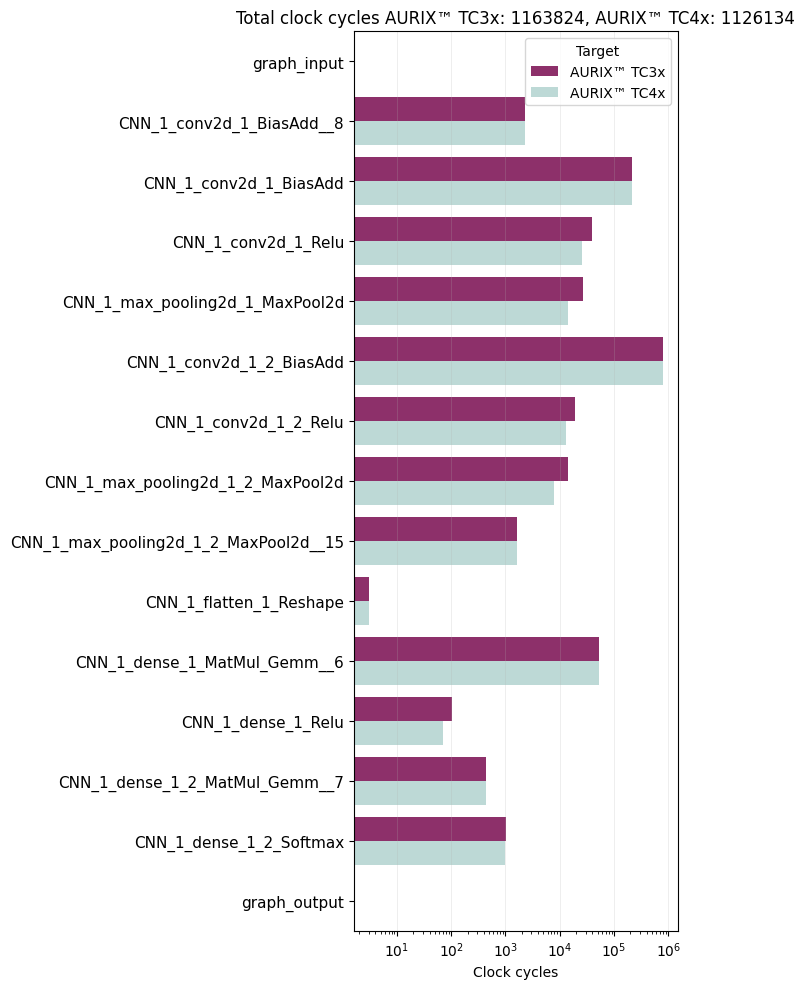

In [11]:
plot_execution_timing(model_name)